In [1]:
using ProgressMeter
using MLDataPattern
import Nets
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
include("pympc.jl")

Test Summary:    | Pass  Total
test sensitivity |  267    267


PyMPC

In [4]:
l = 1.
g = 10.
N = 10
ω = √(g/l)

A = [
    0. 0 1 0
    0  0 0 1
    ω^2  0 0 0
    0  ω^2 0 0
    ]
B = [
    0. 0
    0 0
    -ω^2 0
    0 -ω^2
    ]
Δt = 0.1
pysys = PyMPC.dynamical_systems.DTLinearSystem[:from_continuous](A, B, Δt)

x_max = [0.1, 0.1, 0.1, 0.1]
x_min = -x_max
u_max = [0.1, 0.1]
u_min = -u_max

Q = 10 * eye(4)
R = eye(2)

X_bounds = PyMPC.geometry.Polytope[:from_bounds](reshape(10*x_min, 4, 1), reshape(10*x_max, 4, 1))[:assemble]()
U_bounds = PyMPC.geometry.Polytope[:from_bounds](reshape(u_min, 2, 1), reshape(u_max, 2, 1))[:assemble]()
controller = PyMPC.control.MPCController(pysys, N, "two", Q, R, X=X_bounds, U=U_bounds)

PyObject <pympc.control.MPCController instance at 0x1300ad9e0>

In [54]:
# explicit_controller = @time control.MPCExplicitController(controller[:condensed_program])

In [5]:
qp = controller[:condensed_program]

num_samples = 1000
data = Vector{Tuple{Vector{Float64}, Matrix{Float64}}}()

@showprogress for i in 1:num_samples
    while true
        x = x_min + rand(length(x_min)) .* (x_max - x_min)
        status, u, J = PyMPC.solve_qp(qp, x)
        if status == :Optimal
            push!(data, (x, hcat(u[1:length(u_min), :], J[1:length(u_min), :])))
            break
        end
    end
end

train_data, test_data = splitobs(data, 0.5);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


In [6]:
widths = [4, 8, 8, 8, 2]
net = Nets.Net(widths)

# sgdopts = Nets.SGDOpts(
#     learning_rate=0.1,
#     batch_size=25)
nepoch = 50

loss = (params, x, y) -> sum(abs2, y - Nets.predict_sensitivity(net, params, x))
loss_no_sensitivity = (params, x, y) -> sum(abs2, y[:, 1] - Nets.predict(net, params, x))

(::#3) (generic function with 1 method)

In [12]:
params = 2 * (rand(net) .- 0.5)
losses = Float64[]

@showprogress for i in 1:nepoch
    Nets.adam!(loss, params, train_data, Nets.AdamOpts(learning_rate=0.1 * 0.95^i, batch_size=25))
    push!(losses, mean(xy -> loss_no_sensitivity(params, xy[1], xy[2]), test_data))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01



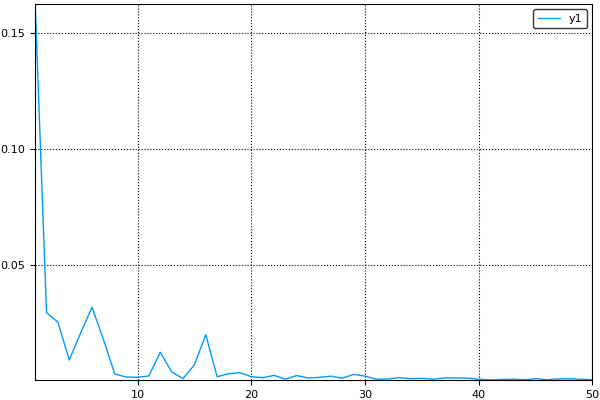

In [13]:
plot(losses)


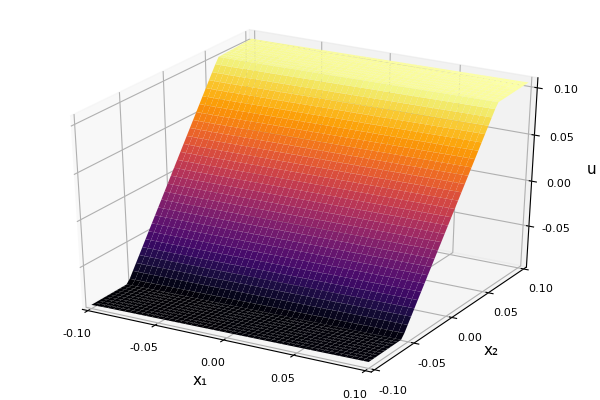

In [14]:
xx = linspace(x_min[1], x_max[1])
yy = linspace(x_min[2], x_max[2])
plt = surface(xx, yy, (x, y) -> Nets.predict(net, params, [x, y, 0, 0])[2], 
legend=nothing,
xlabel="x₁",
ylabel="x₂",
zlabel="u"
)
plt


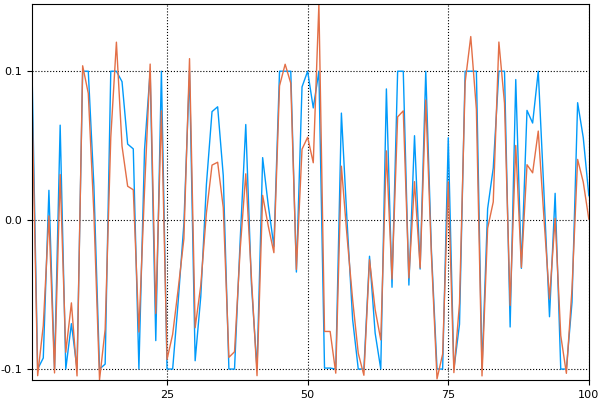

In [15]:
plt = plot([u[1] for (x, u) in test_data[1:100]], legend=nothing)
plot!(plt, [Nets.predict(net, params, x)[1] for (x, u) in test_data[1:100]])
plt


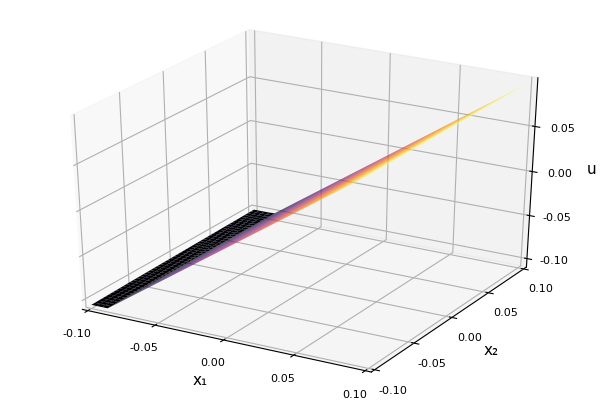

In [16]:
xx = linspace(x_min[1], x_max[1])
yy = linspace(x_min[2], x_max[2])
plt = surface(xx, yy, (x, y) -> Nets.predict(net, params, [x, y, 0, 0])[1], 
legend=nothing,
xlabel="x₁",
ylabel="x₂",
zlabel="u"
)
plt

In [15]:
gui()

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:64
 [2] Array(::Type{Float64}, ::Int64) at ./deprecated.jl:51
 [3] indices at ./abstractarray.jl:57 [inlined]
 [4] indices1 at ./abstractarray.jl:64 [inlined]
 [5] linearindices at ./abstractarray.jl:92 [inlined]
 [6] endof at ./abstractarray.jl:127 [inlined]
 [7] optimize_ticks_typed(::Float64, ::Float64, ::Bool, ::Array{Tuple{Float64,Float64},1}, ::Int64, ::Int64, ::Int64, ::Float64, ::Float64, ::Float64, ::Float64, ::Bool, ::Void) at /Users/rdeits/locomotion/explorations/learning-mpc/packages/v0.6/PlotUtils/src/ticks.jl:162
 [8] (::PlotUtils.#kw##optimize_ticks)(::Array{Any,1}, ::PlotUtils.#optimize_ticks, ::Float64, ::Float64) at ./<missing>:0
 [9] optimal_ticks_and_labels(::Plots.Axis, ::Void) at /Users/rdeits/locomotion/explorations/learning-mpc/packages/v0.6/Plots/src/axes.jl:185
 [10] get_ticks(::Plots.Axis) at /Users/rdeits/locomotion/explorations/learning-mpc/packages/v0.6/Plots/src/axes.jl:228
 [11] _before_layo

In [18]:
using DrakeVisualizer

INFO: Precompiling module DrakeVisualizer.

Use "VoxelIndices{T}(...) where T" instead.
ERROR: LoadError: LoadError: too many parameters for type
Stacktrace:
 [1] include_from_node1(::String) at ./loading.jl:569
 [2] include(::String) at /Applications/Julia-0.6.app/Contents/Resources/julia/lib/julia/sys.dylib:?
 [3] include_from_node1(::String) at /Applications/Julia-0.6.app/Contents/Resources/julia/lib/julia/sys.dylib:?
 [4] include(::String) at /Applications/Julia-0.6.app/Contents/Resources/julia/lib/julia/sys.dylib:?
 [5] anonymous at ./<missing>:2
while loading /Users/rdeits/locomotion/explorations/learning-mpc/packages/v0.6/Meshing/src/marching_tetrahedra.jl, in expression starting on line 521
while loading /Users/rdeits/locomotion/explorations/learning-mpc/packages/v0.6/Meshing/src/Meshing.jl, in expression starting on line 8
ERROR: LoadError: Failed to precompile Meshing to /Users/rdeits/locomotion/explorations/learning-mpc/packages/lib/v0.6/Meshing.ji.
Stacktrace:
 [1] compilec

LoadError: [91mFailed to precompile DrakeVisualizer to /Users/rdeits/locomotion/explorations/learning-mpc/packages/lib/v0.6/DrakeVisualizer.ji.[39m